In [1]:
from warnings import filterwarnings

filterwarnings('ignore')

import numpy as np
import pandas as pd

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pywt
from scipy.fftpack import fft

from modules.data_fetcher import download_historical_data

In [2]:
dataset = "https://raw.githubusercontent.com/taspinar/siml/master/datasets/sst_nino3.dat.txt"
df_nino = pd.read_table(dataset)
N = df_nino.shape[0]
t0=1871
dt=0.25
time = np.arange(0, N) * dt + t0
signal = df_nino.values.squeeze()
df_nino.head()

,-0.15
0,-0.30
1,-0.14
2,-0.41
3,-0.46
4,-0.66


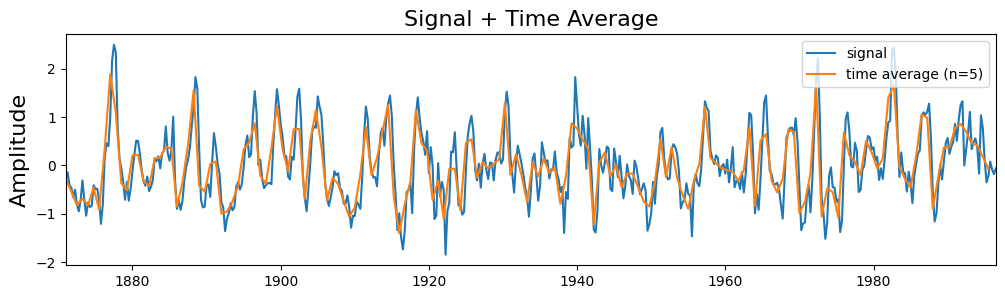

In [3]:
def get_ave_values(xvalues, yvalues, n = 5):
    signal_length = len(xvalues)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(xvalues)
    yarr = np.array(yvalues)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave

def plot_signal_plus_average(ax, time, signal, average_over = 5):
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(5))
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Amplitude', fontsize=16)
    ax.set_title('Signal + Time Average', fontsize=16)
    ax.legend(loc='upper right')

fig, ax = plt.subplots(figsize=(12,3))
plot_signal_plus_average(ax, time, signal, average_over = 3)
plt.show()

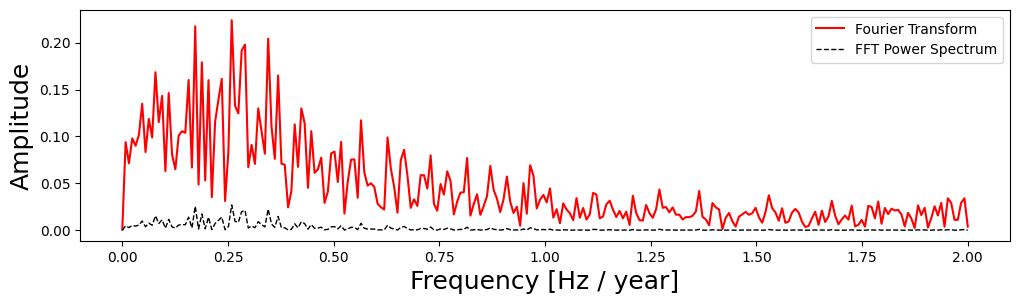

In [4]:
def get_fft_values(y_values, T, N, f_s):
    N2 = 2 ** (int(np.log2(N)) + 1) # round up to next highest power of 2
    f_values = np.linspace(0.0, 1.0/(2.0*T), N2//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N2 * np.abs(fft_values_[0:N2//2])
    return f_values, fft_values

def plot_fft_plus_power(ax, time, signal, plot_direction='horizontal', yticks=None, ylim=None):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2
    if plot_direction == 'horizontal':
        ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
        ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    elif plot_direction == 'vertical':
        scales = 1./f_values
        scales_log = np.log2(scales)
        ax.plot(fft_values, scales_log, 'r-', label='Fourier Transform')
        ax.plot(fft_power, scales_log, 'k--', linewidth=1, label='FFT Power Spectrum')
        ax.set_yticks(np.log2(yticks))
        ax.set_yticklabels(yticks)
        ax.invert_yaxis()
        ax.set_ylim(ylim[0], -1)
    ax.legend()

fig, ax = plt.subplots(figsize=(12,3))
ax.set_xlabel('Frequency [Hz / year]', fontsize=18)
ax.set_ylabel('Amplitude', fontsize=18)
plot_fft_plus_power(ax, time, signal)
plt.show()

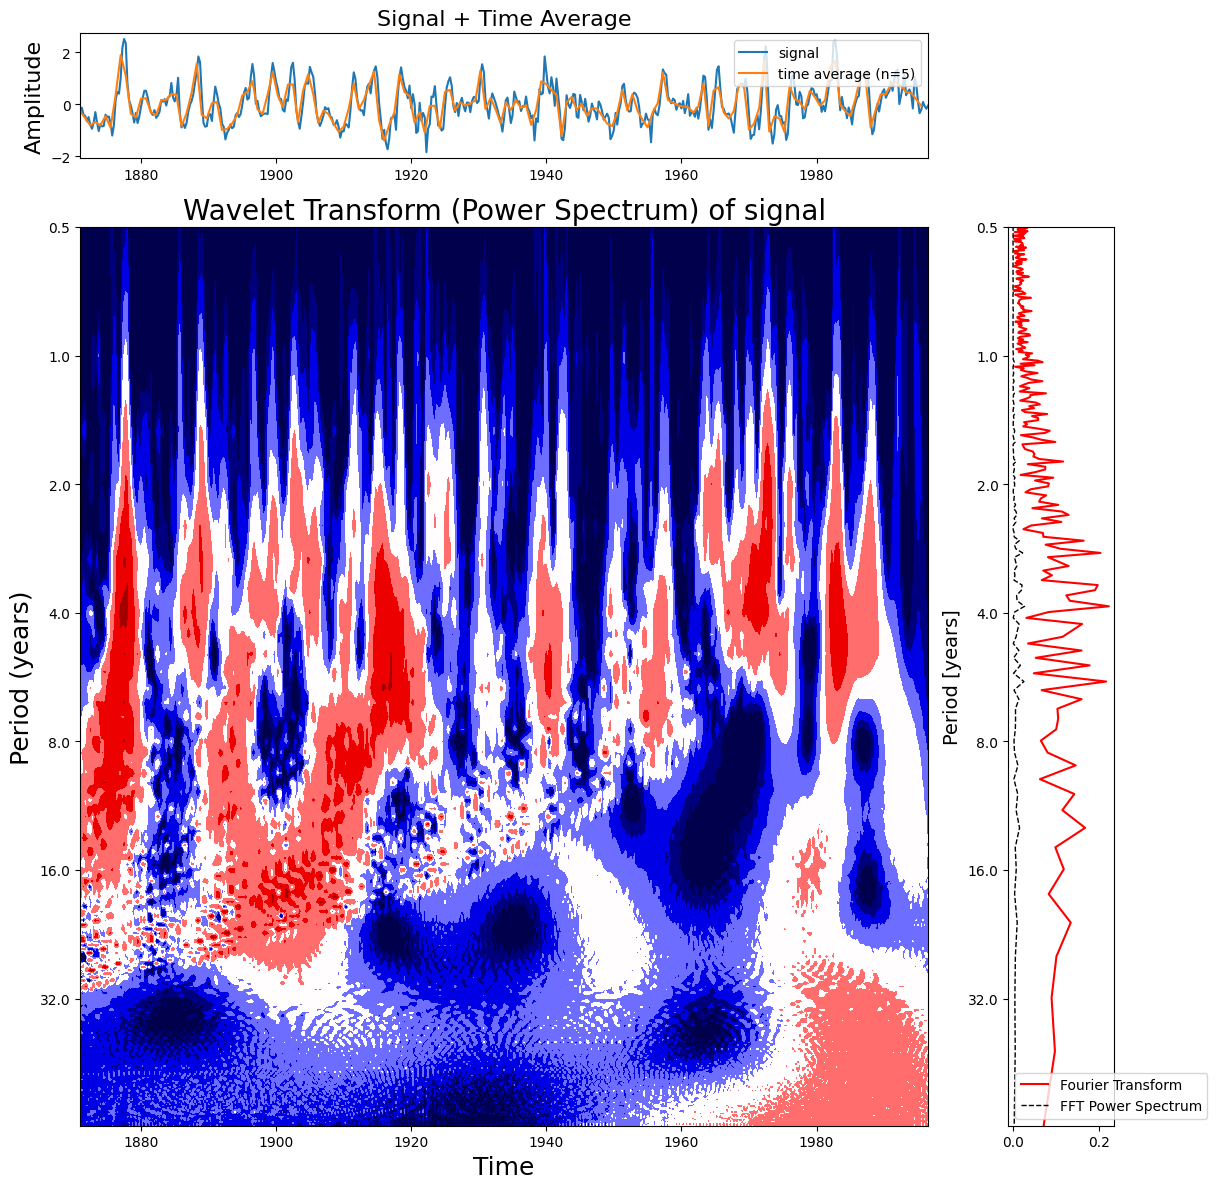

In [6]:
import matplotlib.gridspec as gridspec

def plot_wavelet(ax, time, signal, scales, waveletname = 'cmor', 
                 cmap = plt.cm.seismic, title = '', ylabel = '', xlabel = ''):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    return yticks, ylim
scales = np.arange(1, 128)
title = 'Wavelet Transform (Power Spectrum) of signal'
ylabel = 'Period (years)'
xlabel = 'Time'

fig = plt.figure(figsize=(12,12))
spec = gridspec.GridSpec(ncols=6, nrows=6)
top_ax = fig.add_subplot(spec[0, 0:5])
bottom_left_ax = fig.add_subplot(spec[1:, 0:5])
bottom_right_ax = fig.add_subplot(spec[1:, 5])

plot_signal_plus_average(top_ax, time, signal, average_over = 3)
yticks, ylim = plot_wavelet(bottom_left_ax, time, signal, scales, xlabel=xlabel, ylabel=ylabel, title=title)

plot_fft_plus_power(bottom_right_ax, time, signal, plot_direction='vertical', yticks=yticks, ylim=ylim)
bottom_right_ax.set_ylabel('Period [years]', fontsize=14)
plt.tight_layout()
plt.show()

# CNN on PowerSpectrum

In [2]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History 
history = History()

2023-02-27 14:44:49.880742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 14:44:50.720387: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-27 14:44:50.720447: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-27 14:44:54.320916: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

[The dataset](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones)

In [3]:
activities_description = {
    1: 'walking',
    2: 'walking upstairs',
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}

def read_signals(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
    return data

def read_labels(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(lambda x: int(x)-1, activities))
    return activities

def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

INPUT_FOLDER_TRAIN = '../data/train/Inertial Signals/'
INPUT_FOLDER_TEST = '../data/test/Inertial Signals/'

INPUT_FILES_TRAIN = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                     'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']

INPUT_FILES_TEST = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt',
                     'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']

LABELFILE_TRAIN = '../data/train/y_train.txt'
LABELFILE_TEST = '../data/test/y_test.txt'

train_signals, test_signals = [], []

for input_file in INPUT_FILES_TRAIN:
    signal = read_signals(INPUT_FOLDER_TRAIN + input_file)
    train_signals.append(signal)
train_signals = np.transpose(np.array(train_signals), (1, 2, 0))

for input_file in INPUT_FILES_TEST:
    signal = read_signals(INPUT_FOLDER_TEST + input_file)
    test_signals.append(signal)
test_signals = np.transpose(np.array(test_signals), (1, 2, 0))

train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)

[no_signals_train, no_steps_train, no_components_train] = np.shape(train_signals)
[no_signals_test, no_steps_test, no_components_test] = np.shape(test_signals)
no_labels = len(np.unique(train_labels[:]))

print("The train dataset contains {} signals, each one of length {} and {} components ".format(no_signals_train, no_steps_train, no_components_train))
print("The test dataset contains {} signals, each one of length {} and {} components ".format(no_signals_test, no_steps_test, no_components_test))
print("The train dataset contains {} labels, with the following distribution:\n {}".format(np.shape(train_labels)[0], Counter(train_labels[:])))
print("The test dataset contains {} labels, with the following distribution:\n {}".format(np.shape(test_labels)[0], Counter(test_labels[:])))

uci_har_signals_train, uci_har_labels_train = randomize(train_signals, np.array(train_labels))
uci_har_signals_test, uci_har_labels_test = randomize(test_signals, np.array(test_labels))

The train dataset contains 7352 signals, each one of length 128 and 9 components 
The test dataset contains 2947 signals, each one of length 128 and 9 components 
The train dataset contains 7352 labels, with the following distribution:
 Counter({5: 1407, 4: 1374, 3: 1286, 0: 1226, 1: 1073, 2: 986})
The test dataset contains 2947 labels, with the following distribution:
 Counter({5: 537, 4: 532, 0: 496, 3: 491, 1: 471, 2: 420})


In [4]:
scales = range(1,128)
waveletname = 'morl'
train_size = 5000
train_data_cwt = np.ndarray(shape=(train_size, 127, 127, 9))


In [24]:
train_signals.shape

(7352, 128, 9)

In [7]:
train_data_cwt[0][0][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [8]:
train_data_cwt[0,0,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [15]:
signal

array([-0.3769559 , -0.4932536 , -0.6549152 , -0.612745  , -0.3086814 ,
       -0.04800516, -0.01306415, -0.09583079, -0.01412091,  0.05444375,
       -0.08295644, -0.1918355 , -0.2618297 , -0.2570235 , -0.2418106 ,
       -0.3522296 , -0.3760452 , -0.3704525 , -0.3610282 , -0.233106  ,
       -0.1485568 , -0.1418362 , -0.3578673 , -0.7897239 , -0.9105584 ,
       -0.5540199 , -0.1244006 , -0.03935228, -0.2306413 , -0.2887743 ,
       -0.1114952 ,  0.07310365,  0.05925915, -0.103085  , -0.3019098 ,
       -0.4831235 , -0.5469067 , -0.5653511 , -0.5538851 , -0.4444539 ,
       -0.3410684 , -0.2135733 , -0.1483129 , -0.3117241 , -0.4292462 ,
       -0.2932607 , -0.07418516,  0.04036527,  0.03998071,  0.09109137,
        0.1685214 ,  0.01334599, -0.2251376 , -0.2435935 , -0.2799698 ,
       -0.4637567 , -0.5840759 , -0.6091293 , -0.4732688 , -0.2508058 ,
       -0.1737696 , -0.2433601 , -0.4610008 , -0.725113  , -0.741379  ,
       -0.4853751 , -0.2421035 , -0.1723525 , -0.1944506 , -0.15

In [16]:
train_data_cwt.shape

(5000, 127, 127, 9)

In [17]:
train_data_cwt[0, :, :, 0]

array([[ 0.0713642 ,  0.1535721 , -0.06779071, ...,  0.02289479,
        -0.0064464 ,  0.0029857 ],
       [ 0.02976661, -0.19680638,  0.1267325 , ...,  0.00683947,
         0.02364205, -0.0097335 ],
       [-0.17336748, -0.48521691,  0.20434765, ..., -0.09859893,
         0.11475464,  0.04571212],
       ...,
       [ 0.08701002,  0.04209241,  0.1570216 , ...,  0.05658675,
         0.06536542,  0.07774989],
       [ 0.06851109,  0.05191957,  0.20063612, ...,  0.00451802,
         0.01329474,  0.05244721],
       [ 0.09071275,  0.05123951,  0.18597706, ...,  0.03762964,
         0.03239145,  0.04089703]])

In [10]:

for jj in range(0,9):
    signal = uci_har_signals_train[0, :, jj]
    coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
    coeff_ = coeff[:,:127]
    train_data_cwt[0, :, :, jj] = coeff_


In [11]:
train_data_cwt[0]

array([[[ 7.13641984e-02, -1.24467918e-02, -1.49753423e-02, ...,
          7.13265496e-02, -1.25329577e-02, -1.51369389e-02],
        [ 1.53572096e-01, -1.39454685e-03, -5.98248470e-03, ...,
          3.21746341e-02,  1.07427945e-02,  2.61363040e-02],
        [-6.77907119e-02,  7.15493935e-03,  2.09370567e-02, ...,
         -7.22771074e-02,  7.60398792e-03,  2.21135867e-02],
        ...,
        [ 2.28947896e-02,  4.19606405e-02, -2.33875671e-02, ...,
          2.29387850e-02,  4.19710659e-02, -2.33917058e-02],
        [-6.44640410e-03,  3.38783237e-02, -5.35716977e-02, ...,
         -4.66576266e-03,  3.37005307e-02, -5.41231713e-02],
        [ 2.98569628e-03,  2.03329539e-02, -7.37352221e-03, ...,
         -1.37237596e-03,  2.08132287e-02, -5.97971258e-03]],

       [[ 2.97666130e-02,  2.30067729e-03, -7.37236185e-03, ...,
          2.97682212e-02,  2.34658577e-03, -7.28863725e-03],
        [-1.96806382e-01,  2.88227773e-03, -4.06221223e-03, ...,
         -2.27651140e-02, -1.46017548e

In [14]:

for ii in range(0,train_size):
    if ii % 1000 == 0:
        print(ii)
    for jj in range(0,9):
        signal = uci_har_signals_train[ii, :, jj]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:127]
        train_data_cwt[ii, :, :, jj] = coeff_

test_size = 500
test_data_cwt = np.ndarray(shape=(test_size, 127, 127, 9))
for ii in range(0,test_size):
    if ii % 100 == 0:
        print(ii)
    for jj in range(0,9):
        signal = uci_har_signals_test[ii, :, jj]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:127]
        test_data_cwt[ii, :, :, jj] = coeff_

0
1000


: 

: 

In [ ]:
x_train = train_data_cwt
y_train = list(uci_har_labels_train[:train_size])
x_test = test_data_cwt
y_test = list(uci_har_labels_test[:test_size])
img_x = 127
img_y = 127
img_z = 9
num_classes = 6

batch_size = 16
epochs = 10

# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
# because the MNIST is greyscale, we only have a single channel - RGB colour images would have 3
input_shape = (img_x, img_y, img_z)

# convert the data to the right type
#x_train = x_train.reshape(x_train.shape[0], img_x, img_y, img_z)
#x_test = x_test.reshape(x_test.shape[0], img_x, img_y, img_z)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices - this is for use in the
# categorical_crossentropy loss below
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape)) 
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=batch_size, 
          epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[history])

train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

In [ ]:
fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
axarr[0].plot(range(1, 11), history.history['acc'], label='train score')
axarr[0].plot(range(1, 11), history.history['val_acc'], label='test score')
axarr[0].set_xlabel('Number of Epochs', fontsize=18)
axarr[0].set_ylabel('Accuracy', fontsize=18)
axarr[0].set_ylim([0,1])
axarr[1].plot(range(1, 11), history.history['acc'], label='train score')
axarr[1].plot(range(1, 11), history.history['val_acc'], label='test score')
axarr[1].set_xlabel('Number of Epochs', fontsize=18)
axarr[1].set_ylabel('Accuracy', fontsize=18)
axarr[1].set_ylim([0.9,1])
plt.legend()
plt.show()